# IMDB sentiment analysis with Naive Bayes model that developed from scratch

## Fetch data

In [1]:
import tensorflow as tf
import numpy as np

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=4000)

word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

In [2]:
len(word_index)

88584

In [3]:
x_train[0:3]

array(["[bos] this film was just brilliant casting location scenery story direction [oov] really suited the part they played and you could just imagine being there robert [oov] is an amazing actor and now the same being director [oov] father came from the same [oov] island as myself so i loved the fact there was a real connection with this film the witty [oov] throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [oov] and would recommend it to everyone to watch and the fly [oov] was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [oov] to the two little [oov] that played the [oov] of norman and paul they were just brilliant children are often left out of the [oov] list i think because the stars that play them all grown up are such a big [oov] for the whole film but these children are amazing and should be [oov] for what they hav

## Create the vocabulary

In [4]:
vocabulary = list()
for text in x_train:
  tokens = text.split()
  vocabulary.extend(tokens)

vocabulary = set(vocabulary)
print(len(vocabulary)) # number of features

3998


## Create binary vectors 

In [5]:
from tqdm import tqdm

x_train_binary = list()
x_test_binary = list()

for text in tqdm(x_train):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_train_binary.append(binary_vector)

x_train_binary = np.array(x_train_binary) # an array that in every position there is a sentiment

for text in tqdm(x_test):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_test_binary.append(binary_vector)

x_test_binary = np.array(x_test_binary) # an array that in every position there is a sentiment

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [05:58<00:00, 69.66it/s]


In [6]:
print(x_train_binary)

[[0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [7]:
print(x_train_binary.shape) # 25000 samples and 3998 features

(25000, 3998)


## Bayes Theorem in our case can be written as:
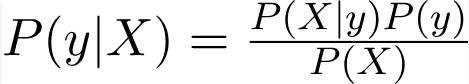

The variable y is the class variable(pos/neg sentiment). Variable X represent the parameters/features.



X is given as:

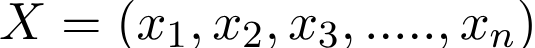

Here x_1,x_2….x_n represent the features, which are 3998. By replacing for X and expanding using the chain rule we get,

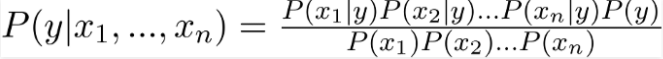

In our case, the class variable(y) has only two outcomes, 0(negative) or 1(positive). There could be cases where the classification could be multivariate. Therefore, we need to select the class y with maximum probability.

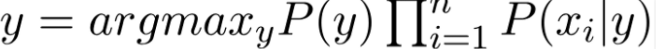

### Prior probability P(y): frequency

### Gaussian Naive Bayes:
When the predictors take up a continuous value and are not discrete, we assume that these values are sampled from a gaussian distribution.

### Class conditional probability P(x_i|y)

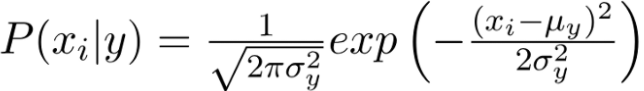

In [8]:
class NaiveBayes:
    def fit(self, X, y):
        number_of_samples, number_of_features = X.shape #25000 and 3998 respectively
        self._classes = np.unique(y)
        number_of_classes = len(self._classes)

        # calculate mean, variance, and prior for each class
        self._mean = np.zeros((number_of_classes, number_of_features), dtype=np.float64)
        self._var = np.zeros((number_of_classes, number_of_features), dtype=np.float64)
        self._priors = np.zeros(number_of_classes, dtype=np.float64)
        
        for index, i in enumerate(self._classes):
            X_i = X[y == i]
            self._mean[index, :] = X_i.mean(axis=0)
            self._var[index, :] = X_i.var(axis=0)
            self._priors[index] = X_i.shape[0] / float(number_of_samples)
            
    def predict(self, X):
        y_predicted = [self.predict_helper(x) for x in X]
        return np.array(y_predicted)

    def predict_helper(self, x):
        posteriors = []
        
        # calculate posterior probability for each class
        for index, c in enumerate(self._classes):
            prior = np.log(self._priors[index])
            posterior = np.sum(np.log(self.posterior_density_function(index, x)))
            posterior = prior + posterior
            posteriors.append(posterior)
            
        # return class with highest posterior probability
        return self._classes[np.argmax(posteriors)]
    
    def posterior_density_function(self, index, x):
        mean = self._mean[index]
        var = self._var[index]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

Let's fit the model and make predictions. Also test the model accuracy

In [10]:
if __name__ == "__main__":
    
    #calculate the accuracy of the model
    def accuracy(y_test, y_predicted):
        accuracy = np.sum(y_test == y_predicted) / len(y_test)
        return accuracy
    
    nb = NaiveBayes()
    nb.fit(x_train_binary, y_train)
    y_pred = nb.predict(x_test_binary)
    
    print("Naive Bayes classification accuracy", accuracy(y_test, y_pred))

C:\Users\Johnny\AppData\Local\Temp/ipykernel_18968/2034112722.py:38: RuntimeWarning: invalid value encountered in true_divide
  numerator = np.exp(-((x - mean) ** 2) / (2 * var))
C:\Users\Johnny\AppData\Local\Temp/ipykernel_18968/2034112722.py:28: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(self.posterior_density_function(index, x)))


Naive Bayes classification accuracy 0.5


In [11]:
from sklearn.metrics import classification_report

print(classification_report(y_test, nb.predict(x_test_binary)))

C:\Users\Johnny\AppData\Local\Temp/ipykernel_18968/2034112722.py:38: RuntimeWarning: invalid value encountered in true_divide
  numerator = np.exp(-((x - mean) ** 2) / (2 * var))
C:\Users\Johnny\AppData\Local\Temp/ipykernel_18968/2034112722.py:28: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(self.posterior_density_function(index, x)))


              precision    recall  f1-score   support

           0       0.50      1.00      0.67     12500
           1       0.00      0.00      0.00     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



C:\Users\Johnny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Johnny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Johnny\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Now let's see the sklearn model 

In [12]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
y_pred = gnb.fit(x_train_binary, y_train).predict(x_test_binary)

print("Number of mislabeled points out of a total %d points : %d" % (x_test_binary.shape[0], (y_test != y_pred).sum()))

Number of mislabeled points out of a total 25000 points : 5600


In [13]:
from sklearn.metrics import classification_report

print(classification_report(y_test, gnb.predict(x_test_binary)))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79     12500
           1       0.82      0.70      0.76     12500

    accuracy                           0.78     25000
   macro avg       0.78      0.78      0.77     25000
weighted avg       0.78      0.78      0.77     25000



It seems that GaussianNB doin' better